In [132]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# The Human Eye

In [133]:
def optimal_dist(size, resolution, max_dist):
    max_spatial_freq = 60
    d = size[0]/(2*np.tan(resolution[0]/(2*max_spatial_freq)))
    return d if (d<max_dist) else max_dist

In [134]:
size = (32, 24) # in Inch
resolution = (1920, 1080)
available_distance = 60 # in Inch
print("A couch at a distance of {} inches from TV will have very high contrast sensitivity.".format(np.round(optimal_dist(size, resolution, available_distance), 2)))

A couch at a distance of 53.22 inches from TV will have very high contrast sensitivity.


# Gray Scale Images

In [135]:
FILEPATH = "../misc/7.2.01.tiff"
img = mpimg.imread(FILEPATH)

## Q1

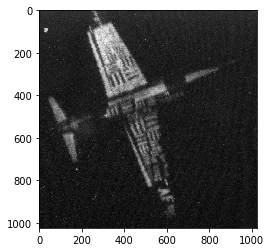

In [136]:
plt.imshow(img, cmap='gray',interpolation='none')

## Q2

In [137]:
minimum_pixel = np.min(img)
maximum_pixel = np.max(img)
print("Maximum pixel value is {} and Minimum value is {} .".format(maximum_pixel, minimum_pixel))

Nbits = int(np.ceil(np.log2(maximum_pixel)))
print("{} bits are used per pixel.".format(Nbits))

Npixels = img.shape[0]*img.shape[1]
print("Resolution of the image is {}x{}, In total of {} pixels are used.".format(img.shape[0], img.shape[1], Npixels))

Maximum pixel value is 192 and Minimum value is 4 .
8 bits are used per pixel.
Resolution of the image is 1024x1024, In total of 1048576 pixels are used.


## Q3

In [138]:
import os

csize = os.path.getsize(FILEPATH)
print("Size of compressed is {} bytes.".format(csize))
print("The compressed image is {}% more than calculated size.".format(((8*csize/(Npixels*Nbits))-1)*100))

Size of compressed is 1048710 bytes.
The compressed image is 0.01277923583984375% more than calculated size.


## Q4

In [139]:
def get_b_coeff(n, b):
    n >>= b
    return n%2

def display_b_plane(I, b):
    bin_img = I.copy()
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            bin_img[i, j] = get_b_coeff(I[i, j], b)
    plt.imshow(bin_img, cmap='gray')
    plt.title("{} Plane".format(b))
    return 
    

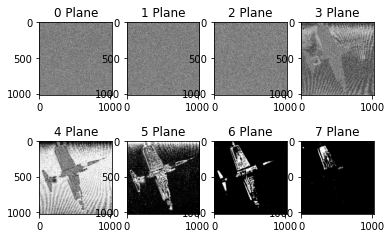

In [200]:
for i in range(Nbits):
    plt.subplot(2, 4, 1+i)
    display_b_plane(img, i)

# Binary Image Processing

## Q1

In [140]:
def histogram(I, Nbits):
    counter = np.zeros(2**Nbits)
    
    for i in I.ravel():
        counter[i] += 1
    return np.array([np.arange(2**Nbits), counter]) 

<BarContainer object of 256 artists>

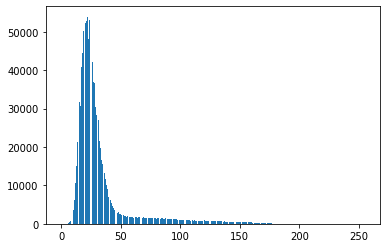

In [141]:
hist = histogram(img, Nbits)
plt.bar(hist[0], hist[1])

## Q2

In [142]:
def thresh(I, T):
    return (I>T).astype(int)

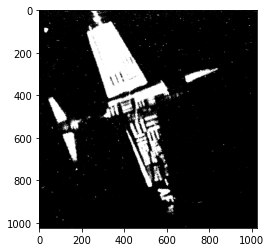

In [143]:
bin_img = thresh(img, 50)
plt.imshow(bin_img, cmap='gray')

## Q3 (a)

In [144]:
def otsu_algo_a(I, Nbits, plot=False):
    bin_I = I.copy()
    hist = histogram(I, Nbits)
    pmf = hist[1]/np.sum(hist[1])
    
    intra_class_var = []
    
    
    for t in range(2**Nbits):
        p0 = np.sum(pmf[0:t])
        p1 = 1-p0
        if(t==0):
            var0 = 0
        else:
            var0 = np.var(pmf[0:t])
        var1 = np.var(pmf[t:])
        intra_class_var.append(p0*var0 + p1*var1)
    
    t0 = np.argmin(intra_class_var)
    
    if(plot==True):
        fig, ax = plt.subplots()
        ax.bar(hist[0, :t0], hist[1, :t0], color="darkorange")
        ax.bar(hist[0, t0:], hist[1, t0:], color="bisque")
        ax2 = ax.twinx()
        ax2.plot(hist[0], intra_class_var)
        ax2.plot(t0, intra_class_var[t0], "*b")
        ax2.plot(t0*np.ones(300), np.linspace(np.min(intra_class_var), 1.1*np.max(intra_class_var), 300), "-r")
    
    return (intra_class_var[t0], t0)

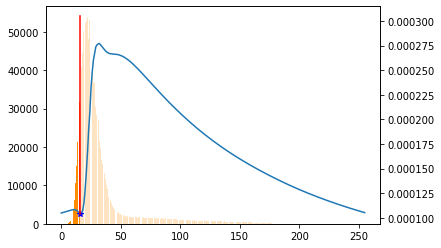

In [145]:
var, t = otsu_algo_a(img, Nbits, plot=True)

Optimal threshould is 16 for which intra-class variance is 0.00010383313168983401.


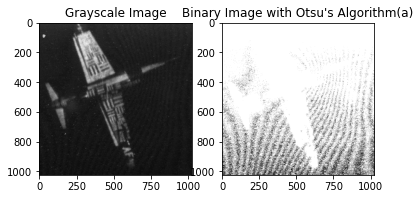

In [146]:
print("Optimal threshould is {} for which intra-class variance is {}.".format(t, var))
bin_img = thresh(img, t)

plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Binary Image with Otsu's Algorithm(a)")
plt.imshow(bin_img, cmap='gray')

## Q3 (b)
Intra-class variance(or Within class Variance) ${\sigma}^2_w = P_0{\sigma}^2_0 + P_1{\sigma}^2_1$\
Intra-class variance(or Within class Variance) ${\sigma}^2_b = P_0{({\mu}_0 - \mu)^2} + P_1{({\mu}_1 - \mu)^2}$\
$\begin{gather*}
{\sigma}^2_b = P_0\left({\mu}_0 - (P_0{\mu_0} + P_1{\mu_1})\right)^2 + P_1\left({\mu}_1 - (P_0{\mu_0} + P_1{\mu_1})\right)^2\\
{\sigma}^2_b = P_0P^2_1({\mu}_0 - {\mu}_1)^2 + P^2_0P_1({\mu}_1 - {\mu}_0)^2\\
\implies \boxed{{\sigma}^2_b = P_0P_1({\mu}_0 - {\mu}_1)^2}
\end{gather*}$

In [147]:
def var_b(P0, mu0, mu1):
    return P0*(1-P0)*np.power(mu0-mu1, 2)
    
def otsu_algo_b(I, Nbits, plot=False):
    hist = histogram(I, Nbits)
    pmf = hist[1]/np.sum(hist[1])
    total_sum = np.sum(hist[1])
    mu = total_sum/hist.shape[1]

    inter_class_var = []
    
    P0 = 0
    mu0 = 0
    inter_class_var.append(var_b(P0, 0, mu))
    for i in range(0, 2**Nbits):
        prev_P0 = P0
        P0 += pmf[i]
        if(P0 == 0):
            inter_class_var.append(0)
        elif(P0 == 1):
            inter_class_var.append(0)
        else:
            mu0 = (mu0*prev_P0 + i*pmf[i])/P0
            mu1 = (mu - mu0*P0)/(1 - P0)
            inter_class_var.append(var_b(P0, mu0, mu1))
        
    t0 = np.argmax(inter_class_var)
    
    if(plot==True):
        fig, ax = plt.subplots()
        ax.bar(hist[0, :t0], hist[1, :t0], color="darkorange")
        ax.bar(hist[0, t0:], hist[1, t0:], color="bisque")
        ax2 = ax.twinx()
        ax2.plot(inter_class_var)
        ax2.plot(t0, inter_class_var[t0], "*b")
        ax2.plot(t0*np.ones(5), np.linspace(np.min(inter_class_var), 1.1*np.max(inter_class_var), 5), "-r")
        
    return (inter_class_var[t0], t0) 

Optimal threshould is 192 for which black-class variance is 17313986249276.19.


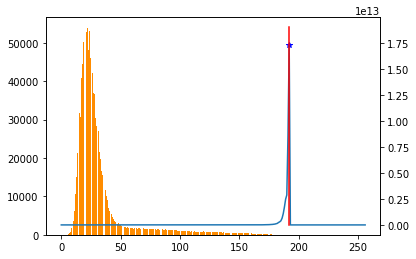

In [148]:
var, t = otsu_algo_b(img, Nbits, plot=True)
print("Optimal threshould is {} for which black-class variance is {}.".format(t, var))

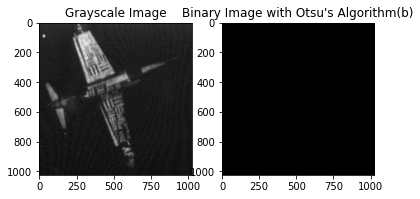

In [149]:
bin_img = thresh(img, t)
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Binary Image with Otsu's Algorithm(b)")
plt.imshow(bin_img, cmap='gray')

## Q4

In [150]:
def complement(bin_I):
    c_bin_I = bin_I.copy()
    for i in range(c_bin_I.shape[0]):
        for j in range(c_bin_I.shape[1]):
            c_bin_I[i, j] = 1 - c_bin_I[i, j]
    return c_bin_I

def connected_component(bin_I):
    R = np.zeros(bin_I.shape)
    k = 1
    for i in range(bin_I.shape[0]):
        for j in range(bin_I.shape[1]):
            if(i == 0 and j == 0):
                if(bin_I[0, 0] == 0):
                    R[i, j] = k
                    k += 1
            elif(i == 0):
                if(bin_I[i, j-1] == 0 and bin_I[i, j] == 0):
                    R[i, j] = R[i, j-1]
                elif(bin_I[i, j] == 0):
                    R[i, j] = k
                    k += 1
            elif(j == 0):
                if(bin_I[i-1, j] == 0 and bin_I[i, j] == 0):
                    R[i, j] = R[i-1, j]
                elif(bin_I[i, j] == 0):
                    R[i, j] = k
                    k += 1
            else:
                if(bin_I[i, j] == 0):
                    if(bin_I[i-1, j] == 0 and bin_I[i, j-1] == 0):
                        if(R[i-1, j] != R[i, j-1]):
                            R[i, j] = min(R[i-1, j], R[i, j-1])
                        else:
                            R[i, j] = min(R[i-1, j], R[i, j-1])
                    elif(bin_I[i-1, j] == 0):
                        R[i, j] = R[i-1, j]
                    elif(bin_I[i, j-1] == 0):
                        R[i, j] = R[i, j-1]
                    else:
                        R[i, j] = k
                        k += 1
    return R

In [151]:
c_bin_img = complement(bin_img)
R = connected_component(bin_img)
print(R)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


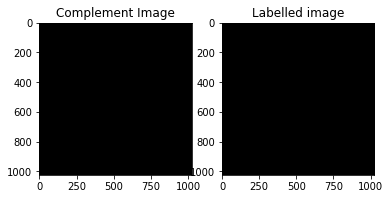

In [152]:
plt.subplot(1, 2, 1)
plt.title("Complement Image")
plt.imshow(bin_img, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Labelled image")
plt.imshow(255*R/np.max(R), cmap="gray")

## Q5

In [153]:
(label, area) = np.unique(R, return_counts=True)

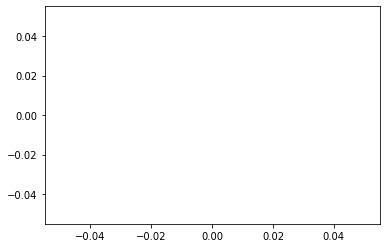

In [154]:
plt.plot(label[2:], area[2:])

In [155]:
def minor_blob_removal(I, R, m):
    new_I = I.copy()
    for i in range(new_I.shape[0]):
        for j in range(new_I.shape[1]):
            if(new_I[i, j]==0 and R[i, j]==m):
                new_I[i, j] = 1
    return new_I

In [ ]:
mbr_img = minor_blob_removal(bin_img, R, 1)
for i in range(2, 200):
    mbr_img = minor_blob_removal(mbr_img, R, i)

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Before Minor blob removal")
plt.imshow(bin_img, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("After Minor blob removal")
plt.imshow(mbr_img, cmap="gray")